# Analysis

## Data Preparation

In [1]:
import numpy as np
import yfinance as yf

spy_train = yf.download(
    'SPY', 
    start='2000-01-01',
    end='2019-12-31',
    auto_adjust=True, 
    progress=False
)

spy_test = yf.download(
    'SPY', 
    start='2020-01-01',
    end='2025-12-31',
    auto_adjust=True, 
    progress=False
)

logret = np.log(spy_train['Close']).diff().dropna() * 100
logret_test = np.log(spy_test['Close']).diff().dropna() * 100

## Model Selection

We first pick the best model out of the 2, 3, and 4 state HMMs.

We select the number of regimes by BIC, subject to a minimum persistence constraint of > 5 days. Any model that doesn't meet the constraints is automatically degenerate and will be rejected.

In [3]:
from src import models
from src.utils.hmm_fitting import fit_best
from src.utils.info_criteria import bic, aic

hmm2 = fit_best(models.GHMM, data=logret, n_seeds=50, n_states=2)
hmm3 = fit_best(models.GHMM, data=logret, n_seeds=50, n_states=3)
hmm4 = fit_best(models.GHMM, data=logret, n_seeds=50, n_states=4)
hmm5 = fit_best(models.GHMM, data=logret, n_seeds=50, n_states=5)

all_hmms = [hmm2, hmm3, hmm4, hmm5]

In [4]:
from src.utils.hmm_diagnostics import print_exp_durations

for hmm in all_hmms: 
    print(f"{hmm.n_states}-state HMM BIC: {bic(hmm.loglik, hmm.n_params, len(logret)):.6f}")
print()

for hmm in all_hmms:
    print_exp_durations(hmm)
    print()

2-state HMM BIC: 14044.446018
3-state HMM BIC: 13639.099626
4-state HMM BIC: 13598.681973
5-state HMM BIC: 13614.241795

2-State HMM Expected Durations:
State 0 Expected Duration: 78.832075
State 1 Expected Duration: 36.408954

3-State HMM Expected Durations:
State 0 Expected Duration: 41.055614
State 1 Expected Duration: 27.025845
State 2 Expected Duration: 28.732071

4-State HMM Expected Durations:
State 0 Expected Duration: 20.257385
State 1 Expected Duration: 16.183948
State 2 Expected Duration: 21.468407
State 3 Expected Duration: 38.650399

5-State HMM Expected Durations:
State 0 Expected Duration: 1.069582
State 1 Expected Duration: 3.949214
State 2 Expected Duration: 12.088245
State 3 Expected Duration: 40.075744
State 4 Expected Duration: 21.930227



We reject the 4-state HMM as degenerate due to low persistence of 3.4 days and 1.5 days for regimes 1 and 3 respectively. Such short expected durations violate the interpretation of regimes as persistent latent states and instead suggest overfitting through state-splitting.

Among non-degenerate models, the 3-state HMM achieves the lowest BIC. Based on likelihood-based selection, persistence constraints, and regime interpretability diagnostics, we select the 3-state HMM for subsequent analysis.

## Model Validation

In [5]:
import src.utils.hmm_diagnostics as diag

diag.print_transition_matrix(hmm4)
print()
diag.print_exp_durations(hmm4)
print()
diag.print_state_stats(hmm4, logret)
print()
diag.print_params(hmm4)

4-State HMM Transition Matrix:
State 0: 0.950635 0.047094 0.000000 0.002271
State 1: 0.050685 0.938210 0.000000 0.011104
State 2: 0.000000 0.000000 0.953420 0.046580
State 3: 0.000000 0.019777 0.006096 0.974127

4-State HMM Expected Durations:
State 0 Expected Duration: 20.257385
State 1 Expected Duration: 16.183948
State 2 Expected Duration: 21.468407
State 3 Expected Duration: 38.650399

4-State HMM Sample Statistics:
State    Count        Mean    Variance
0         1815    0.110174    0.218338
1         1671    0.032102    0.827914
2          155   -0.271327   14.210228
3         1388   -0.068357    2.285472

4-State HMM Parameters:
State       Mean  Variance
0       0.123712  0.214222
1       0.020363  0.834960
2      -0.262877 12.460203
3      -0.075164  2.341928


There is strong temporal persistence for each regime, with the minimum being ~3 weeks (21 days). The means are quite small, with clear between-regime volatility seperation. This indicates that regimes are driven by volatility differences, not drift. 

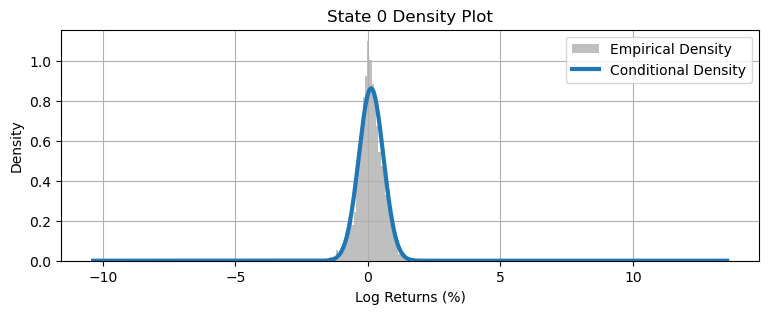

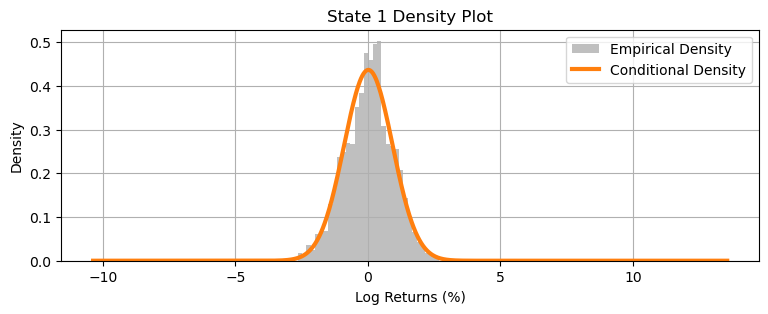

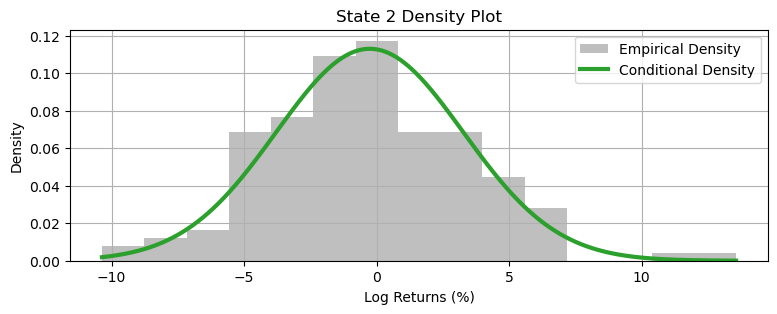

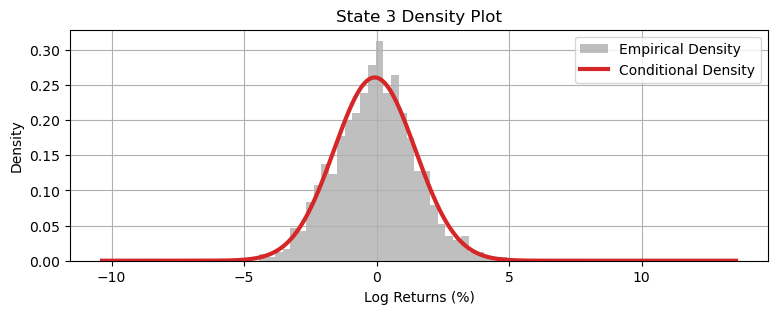

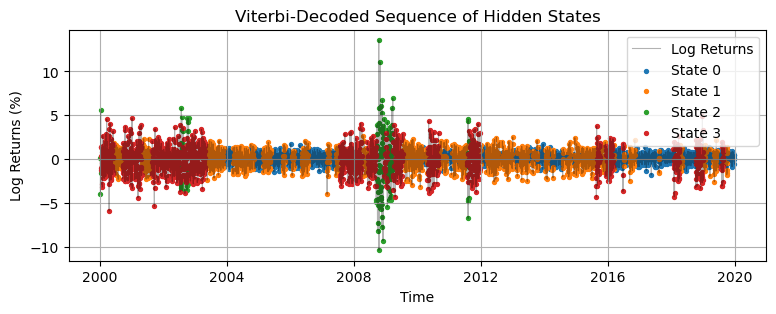

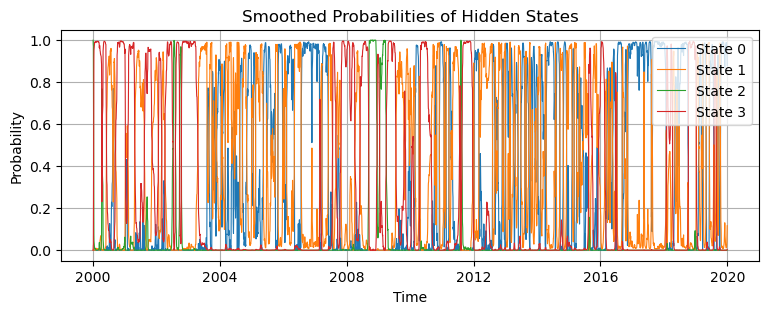

In [6]:
import src.plots.hmm_plots as plot

plot.plot_densities(hmm4, logret)
plot.plot_viterbi_seq(hmm4, logret)
plot.plot_probs(hmm4, logret)

Higher-volatility regimes correspond directly to key economic regimes such as the 2008 finanical crisis, COVID-19, etc. There is also bery high certainty in the smoothed state probabilities.

## Benchmarking with Predictive Log Score

In [7]:
gaussian = models.Gaussian()
student_t = models.StudentT()
garch = models.GARCH()
benchmarks = [gaussian, student_t, garch]
for model in benchmarks: 
    model.fit(logret)

all_models = {
    '4-state HMM' : hmm4,
    'Gaussian' : gaussian,
    'Student_t' : student_t, 
    'GARCH(1,1)' : garch
}

print(f"{'Model':<12}{'AIC':>14}{'BIC':>14}{'Log-Score':>12}")
for name, model in all_models.items(): 
    print(f"{name:<12}" +
          f"{aic(model.loglik, model.n_params):14.6f}" +
          f"{bic(model.loglik, model.n_params, len(logret)):14.6f}", 
          end = ""
         )
    if name == '4-state HMM': 
        print(f"{model.log_predictive_density(logret_test, logret).mean():12.6f}")
    else:
        print(f"{model.log_predictive_density(logret_test).mean():12.6f}")

Model                  AIC           BIC   Log-Score
4-state HMM   13448.653515  13598.681973   -1.412108
Gaussian      16063.563358  16076.609311   -1.698295
Student_t     14663.974957  14683.543887   -1.522812
GARCH(1,1)    13673.570437  13699.662342   -1.326119
